# Exploring Mental Health Data
Source: https://www.kaggle.com/competitions/playground-series-s4e11

Followed this set-up a bit. I like the flow: https://www.kaggle.com/code/oscarm524/ps-s4-ep11-eda-modeling-submission

In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import jax
from jax.lib import xla_bridge
from jax import config
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import flax.linen as nn
from flax.training.train_state import TrainState
import optax

import shap

## CPU/GPUTPU detection and configuration

This will be checking whether other processors are available other than CPU. If so, it will use the available ones. 
We recommend using GPUs when working with JAX on Kaggle. These notebooks are compatible with the v3-8 TPUs that are provided for free in Kaggle Notebooks, but JAX was optimized for the newly updated TPU VM architecture which is not yet available on Kaggle.


In [443]:
# Shows the list of the available devices
jax.local_devices()

[CpuDevice(id=0)]

In [444]:
# Check for TPU or GPU
if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
    try:
        if xla_bridge.get_backend("gpu").platform == "gpu":
            print('GPU detected.')
    except RuntimeError as e:
        config.update("jax_platform_name", "cpu")
        print('No TPU or GPU detected. Using CPU.')

# Show the list of available devices
print(jax.local_devices())

No TPU or GPU detected. Using CPU.
[CpuDevice(id=0)]


/var/folders/bs/gvm42h356mz5vjf9v118br000000gn/T/ipykernel_61973/969141388.py:13: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  if xla_bridge.get_backend("gpu").platform == "gpu":


## Data Reading and Processing

In [445]:
# get data
data_path = Path("~/Data/mental_health/")
train = pd.read_csv(data_path/ "train.csv", header = 0, index_col = 0)
test = pd.read_csv(data_path/ "test.csv", header = 0, index_col = 0)
submission = pd.read_csv(data_path/ "sample_submission.csv")


train.shape, test.shape, submission.shape

((140700, 19), (93800, 18), (93800, 2))

In [446]:
train.head()

,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
id,,,,,,,,,,,,,,,,,,,
0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [447]:
# Check for missing values
print('--- Percentage of Missing Values in Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Percentage of Missing Values in Test ---\n')
print(100*test.isnull().sum() / test.shape[0])

--- Percentage of Missing Values in Train ---

Name                                      0.000000
Gender                                    0.000000
Age                                       0.000000
City                                      0.000000
Working Professional or Student           0.000000
Profession                               26.034115
Academic Pressure                        80.172708
Work Pressure                            19.842217
CGPA                                     80.171997
Study Satisfaction                       80.172708
Job Satisfaction                         19.836532
Sleep Duration                            0.000000
Dietary Habits                            0.002843
Degree                                    0.001421
Have you ever had suicidal thoughts ?     0.000000
Work/Study Hours                          0.000000
Financial Stress                          0.002843
Family History of Mental Illness          0.000000
Depression                         

In [448]:
# Check for duplicated rows
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the Depression column, there are {sum(train.drop(columns=['Depression'], axis=1).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the Depression column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.
There are 0 duplicated rows in the test data frame.


### Data Exploration ###

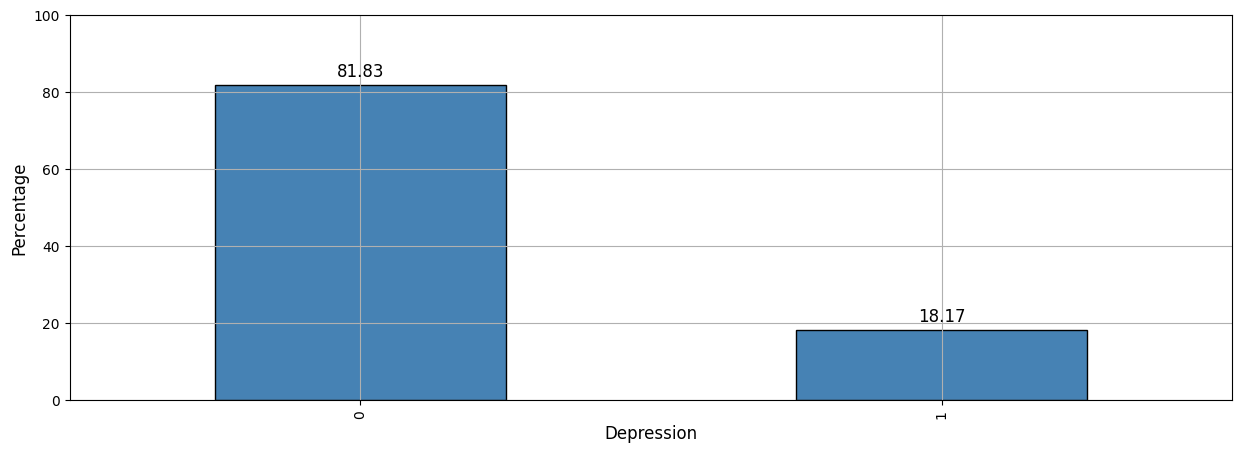

In [449]:
# Plot the distribution of Depression
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = round(train['Depression'].value_counts(normalize=True) * 100, 2).plot(kind='bar', color='steelblue', edgecolor='black')
ax.bar_label(ax.containers[0], label_type='edge', fontsize=12, padding=3)
ax.set_ylabel("Percentage", fontsize=12)
ax.set_xlabel("Depression", fontsize=12)
ax.set_ylim(0, 100)
ax.grid(True)
plt.show()

# We see that we have an imbalanced dataset. We will need to address this later on.

In [450]:
train.columns

Index(['Name', 'Gender', 'Age', 'City', 'Working Professional or Student',
       'Profession', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration',
       'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?',
       'Work/Study Hours', 'Financial Stress',
       'Family History of Mental Illness', 'Depression'],
      dtype='object')

In [451]:
# For the categorical variables, count the number of unique values
for col in train.columns:
    if train[col].dtype == 'object':
        print(f"{col}: {train[col].nunique()} unique values")

Name: 422 unique values
Gender: 2 unique values
City: 98 unique values
Working Professional or Student: 2 unique values
Profession: 64 unique values
Sleep Duration: 36 unique values
Dietary Habits: 23 unique values
Degree: 115 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values


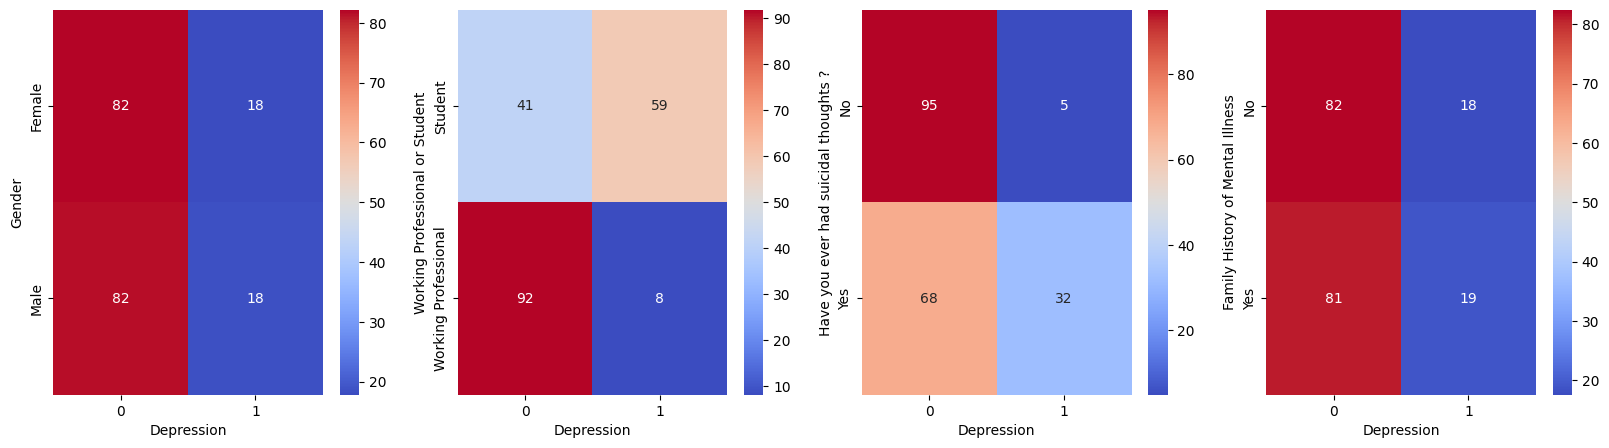

In [452]:
# Look at the relationship between the features and the target variable
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data=round(100*pd.crosstab(train['Gender'], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[0])
sns.heatmap(data=round(100*pd.crosstab(train['Working Professional or Student'], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[1])
sns.heatmap(data=round(100*pd.crosstab(train["Have you ever had suicidal thoughts ?"], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[2])
sns.heatmap(data=round(100*pd.crosstab(train["Family History of Mental Illness"], train['Depression'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=ax[3])
plt.show()

In [453]:
train.dtypes

Name                                      object
Gender                                    object
Age                                      float64
City                                      object
Working Professional or Student           object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                         float64
Family History of Mental Illness          object
Depression                                 int64
dtype: object

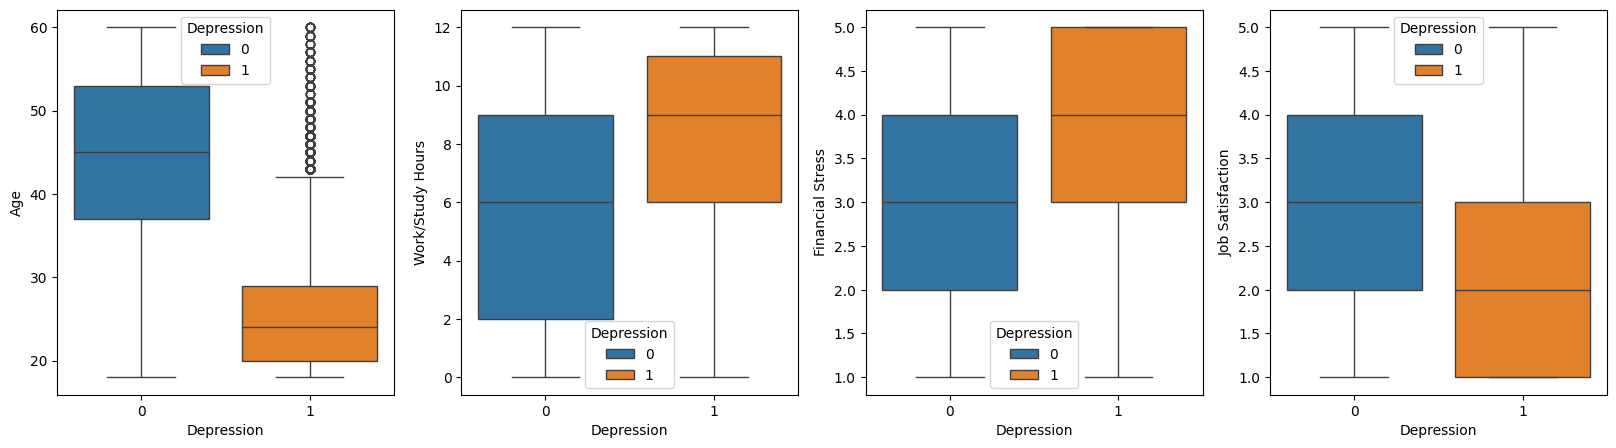

In [454]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(x='Depression', y='Age', data=train, hue="Depression", ax=ax[0])
sns.boxplot(x='Depression', y='Work/Study Hours', data=train, hue="Depression", ax=ax[1])
sns.boxplot(x='Depression', y='Financial Stress', data=train, hue="Depression", ax=ax[2])
sns.boxplot(x='Depression', y='Job Satisfaction', data=train, hue="Depression", ax=ax[3])
plt.show()

## Preparing Data

I will be using the continuous data and categorical data with only two categories to keep it simple.

In [455]:
# Count the number of unique values for each categorical variable
for col in train.columns:
    if train[col].dtype == 'object':
        print(f"{col}: {train[col].nunique()} unique values")

Name: 422 unique values
Gender: 2 unique values
City: 98 unique values
Working Professional or Student: 2 unique values
Profession: 64 unique values
Sleep Duration: 36 unique values
Dietary Habits: 23 unique values
Degree: 115 unique values
Have you ever had suicidal thoughts ?: 2 unique values
Family History of Mental Illness: 2 unique values


In [456]:
# Select the columns that are continuous and have 2 categories
selected_columns = [
    'Gender', 
    'Working Professional or Student', 
    'Have you ever had suicidal thoughts ?', 
    'Family History of Mental Illness', 
    'Age', 
    'Work/Study Hours', 
    'Financial Stress', 
    'Job Satisfaction', 
]

# Prepare the data for training
X = train[selected_columns]
y = train['Depression']

# Drop the same columns from the test set
test_selected = test[selected_columns]

In [457]:
# One-hot encode the categorical variables

# Combine train and test to ensure consistent one-hot encoding
combined = pd.concat([X, test_selected], keys=['train', 'test'])

# One-hot encode the categorical variables
cat_cols = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

# Split back into train and test sets
X = combined.xs('train')
test_selected = combined.xs('test')

In [458]:
# Check for NaNs in the data
print('--- Percentage of Missing Values in X_train ---\n')
print(X.isna().sum())
print('\n')
print('--- Percentage of Missing Values in y_train ---\n')
print(y.isna().sum())

--- Percentage of Missing Values in X_train ---

Age                                                         0
Work/Study Hours                                            0
Financial Stress                                            4
Job Satisfaction                                        27910
Gender_Male                                                 0
Working Professional or Student_Working Professional        0
Have you ever had suicidal thoughts ?_Yes                   0
Family History of Mental Illness_Yes                        0
dtype: int64


--- Percentage of Missing Values in y_train ---

0


In [459]:
# Fill missing values with the mean of the column for numeric columns
X = X.fillna(X.mean())
test_selected = test_selected.fillna(test_selected.mean())

# Ensure all values are numeric
X = X.apply(pd.to_numeric, errors='coerce')
test_selected = test_selected.apply(pd.to_numeric, errors='coerce')

In [460]:
X.describe()

,Age,Work/Study Hours,Financial Stress,Job Satisfaction,Gender_Male,Working Professional or Student_Working Professional,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes
count,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000,140700.000000
mean,40.388621,6.252679,2.988983,2.974404,0.550561,0.801699,0.494399,0.497100
std,12.384099,3.853615,1.413613,1.267871,0.497439,0.398722,0.499970,0.499993
min,18.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,3.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000
50%,42.000000,6.000000,3.000000,2.974404,1.000000,1.000000,0.000000,0.000000
75%,51.000000,10.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000
max,60.000000,12.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [461]:
# Separate continuous and categorical features
continuous_features = ['Age', 'Work/Study Hours', 'Financial Stress', 'Job Satisfaction']
categorical_features = [col for col in X.columns if col not in continuous_features]

# Apply StandardScaler to continuous features
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X[continuous_features])
test_selected_continuous = scaler.transform(test_selected[continuous_features])

# Combine scaled continuous features and categorical features
X_combined = np.hstack((X_continuous, X[categorical_features].values))
test_selected_combined = np.hstack((test_selected_continuous, test_selected[categorical_features].values))


In [462]:
# Split data into training and validation sets -> 80% train, 20% validation
train_size = int(0.8 * len(X_combined))
X_train, X_test = X_combined[:train_size], X_combined[train_size:]
y_train, y_test = y.values[:train_size], y.values[train_size:]

In [463]:
# Convert data into JAX arrays with specified dtype
X_train_arr = jnp.array(X_train, dtype=jnp.float32)
y_train_arr = jnp.array(y_train, dtype=jnp.float32).reshape(-1, 1)
X_test_arr = jnp.array(X_test, dtype=jnp.float32)
y_test_arr = jnp.array(y_test, dtype=jnp.float32).reshape(-1, 1)
test_arr = jnp.array(test_selected_combined, dtype=jnp.float32)

## Create MLP using JAX
Creating a simple fully connected neural network in JAX/FLAX for predicting depression (binary classification)

In [464]:
# Define Neural Network (MLP)
class SimpleMLP(nn.Module):
    hidden_size: int
    output_size: int  # 1 for binary classification

    # Define the MLP cell
    def setup(self):
        self.hidden_layer = nn.Dense(features=self.hidden_size)
        self.output_layer = nn.Dense(features=self.output_size)
    
    @nn.compact
    def __call__(self, x):
        x = self.hidden_layer(x)
        x = nn.relu(x)
        x = self.output_layer(x)
        return x

## Model Initialisation
In FLAX, you have to manually create and update train_state, which holds all the model's variables.
In Jax, you need a training state to encapsulate the model parameters, optimizer state, and 
apply function. This is easier to manage the JIT compliation and training loop.

In [465]:
# Create training state
def create_train_state(rng, X_train):
    X_batch = X_train[:1, :]  # Take a batch of the data to get the input size
    model = SimpleMLP(hidden_size=64, output_size=1)
    params = model.init(rng, X_batch)["params"]
    tx = optax.adam(learning_rate=1e-3)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)


In [466]:
# Initialis the training state
rng = jax.random.PRNGKey(0)
train_state = create_train_state(rng, X_train_arr)

## Loss & Metrics calculations
Create the functions which calculates the training loss and the accuracy using the given predicted values and labels


In [467]:
# Set up Training Loop, Loss Function and Optimizer
@jax.jit
def binary_cross_entropy_loss(logits, labels):
    # Compute binary cross-entropy loss
    preds = jax.nn.sigmoid(logits)  # Sigmoid activation function to get probabilities
    epsilon = 1e-7  # Small value to avoid log(0)
    loss = -jnp.mean(labels * jnp.log(preds + epsilon) + (1 - labels) * jnp.log(1 - preds + epsilon))
    return loss


# Forward pass and loss calculation (no need to pass the model class)
@jax.jit
def compute_loss(params, batch):
    features, labels = batch
    logits = train_state.apply_fn({'params': params}, features)  # Get raw logits from the model
    return binary_cross_entropy_loss(logits, labels)


## Training

In [468]:
# Training step function (do not pass the model itself)
@jax.jit
def train_step(state, batch):
    loss, grads = jax.value_and_grad(compute_loss)(state.params, batch)  # Compute loss and gradients
    state = state.apply_gradients(grads=grads)  # Apply updates to the model parameters
    return loss, state

# Validation step function
@jax.jit
def validate(params, batch):
    features, labels = batch
    logits = train_state.apply_fn({'params': params}, features)  # Get raw logits from the model
    loss = binary_cross_entropy_loss(logits, labels)
    return loss

# Accuracy calculation
def calculate_accuracy(logits, labels):
    preds = jax.nn.sigmoid(logits)
    predicted_classes = preds > 0.5
    return jnp.mean(predicted_classes == labels)

In [469]:
# Set batch size and number of epochs
batch_size = 32 
num_epochs = 20  # Increased number of epochs

# Training loop with validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
start = time.time()
for epoch in range(num_epochs):
    # Shuffle data for each epoch
    idx = jax.random.permutation(rng, X_train_arr.shape[0])
    X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

    # Training
    train_loss = 0.0
    train_accuracy = 0.0
    for i in range(0, len(X_train_arr), batch_size):
        batch_features = X_train_arr[i:i + batch_size]
        batch_labels = y_train_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one training step
        loss, train_state = train_step(train_state, batch)
        train_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features)
        train_accuracy += calculate_accuracy(logits, batch_labels)

    train_loss /= (len(X_train_arr) // batch_size)
    train_accuracy /= (len(X_train_arr) // batch_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss = 0.0
    val_accuracy = 0.0
    for i in range(0, len(X_test_arr), batch_size):
        batch_features = X_test_arr[i:i + batch_size]
        batch_labels = y_test_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one validation step
        loss = validate(train_state.params, batch)
        val_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features)
        val_accuracy += calculate_accuracy(logits, batch_labels)

    val_loss /= (len(X_test_arr) // batch_size)
    val_accuracy /= (len(X_test_arr) // batch_size)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Total time: ", time.time() - start, "seconds")

Epoch 1/20, Training Loss: 0.2044, Validation Loss: 0.1878, Training Accuracy: 0.9164, Validation Accuracy: 0.9250
Epoch 2/20, Training Loss: 0.1873, Validation Loss: 0.1882, Training Accuracy: 0.9235, Validation Accuracy: 0.9236
Epoch 3/20, Training Loss: 0.1866, Validation Loss: 0.1857, Training Accuracy: 0.9242, Validation Accuracy: 0.9253
Epoch 4/20, Training Loss: 0.1862, Validation Loss: 0.1859, Training Accuracy: 0.9243, Validation Accuracy: 0.9252
Epoch 5/20, Training Loss: 0.1860, Validation Loss: 0.1869, Training Accuracy: 0.9245, Validation Accuracy: 0.9244
Epoch 6/20, Training Loss: 0.1859, Validation Loss: 0.1865, Training Accuracy: 0.9241, Validation Accuracy: 0.9239
Epoch 7/20, Training Loss: 0.1858, Validation Loss: 0.1858, Training Accuracy: 0.9245, Validation Accuracy: 0.9250
Epoch 8/20, Training Loss: 0.1856, Validation Loss: 0.1863, Training Accuracy: 0.9240, Validation Accuracy: 0.9245
Epoch 9/20, Training Loss: 0.1856, Validation Loss: 0.1866, Training Accuracy: 0

## Performance Check
Get the training and validation loss to measure model's performance on training and validation data, respectively. 
Get the training and validation accuracy to measure the proportion of correctly classified samples in the training and validation data, respectively. 

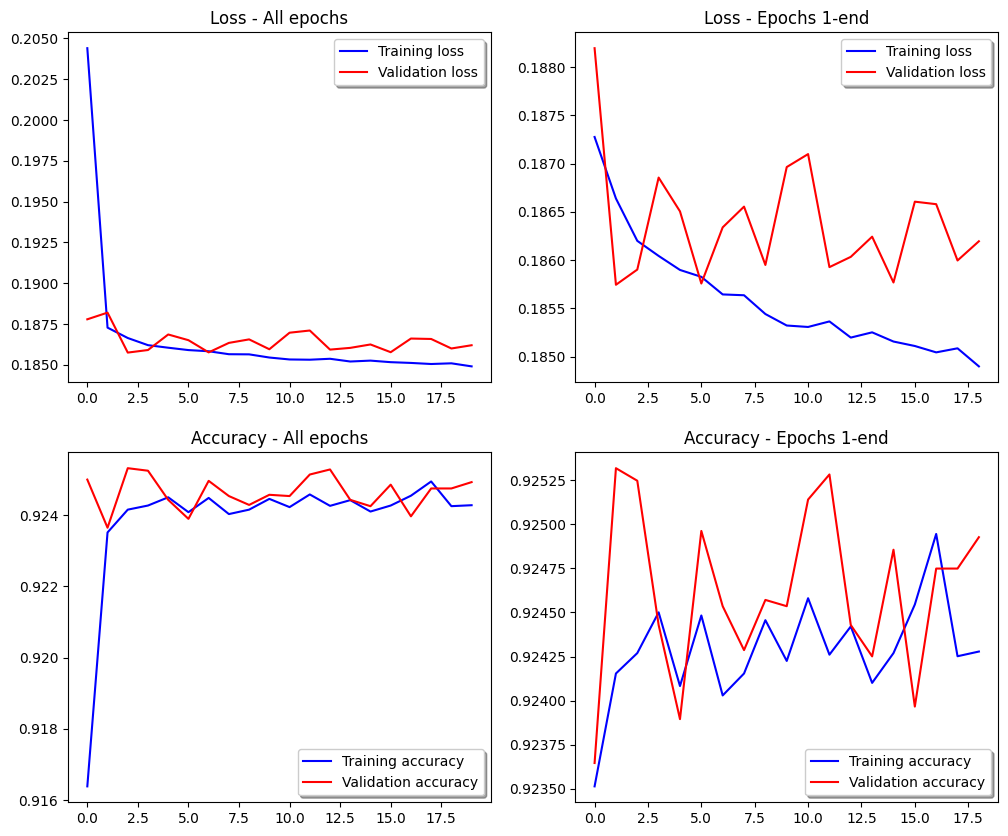

In [470]:
# Plotting the training and validation loss and accuracy
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='b', label="Training loss")
ax[0, 0].plot(val_losses, color='r', label="Validation loss")
ax[0, 0].legend(loc='best', shadow=True)
ax[0, 0].set_title("Loss - All epochs")
ax[0, 1].plot(train_losses[1:], color='b', label="Training loss")
ax[0, 1].plot(val_losses[1:], color='r', label="Validation loss")
ax[0, 1].legend(loc='best', shadow=True)
ax[0, 1].set_title("Loss - Epochs 1-end")
ax[1, 0].plot(train_accuracies, color='b', label="Training accuracy")
ax[1, 0].plot(val_accuracies, color='r', label="Validation accuracy")
ax[1, 0].legend(loc='best', shadow=True)
ax[1, 0].set_title("Accuracy - All epochs")
ax[1, 1].plot(train_accuracies[1:], color='b', label="Training accuracy")
ax[1, 1].plot(val_accuracies[1:], color='r', label="Validation accuracy")
ax[1, 1].legend(loc='best', shadow=True)
ax[1, 1].set_title("Accuracy - Epochs 1-end")
plt.show()

## Prediction
The MLP model produces raw outputs (known as *logits*) from the last layer. These logits are not yet probabilities, but are values that can range from -inf to +inf.
With binary classification, typically a sigmoid function is used to convert these logits into probabilities (between 0 and 1) representing the likelihood of the positive class, i.e. whether the person has depression. 

In binary cross-entropy loss, the loss function operates on the raw logits, because it is numerically more stable when combined with the sigmoid function. 

In [471]:
# Generate predictions for the test set
logits = train_state.apply_fn({'params': train_state.params}, test_arr)  # Get raw logits from the model
test_preds = jax.nn.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
test_preds = (test_preds > 0.5).astype(int)  # Convert probabilities to binary class predictions (0 or 1)

In [472]:
# Create submission file
# submission = pd.read_csv('../input/playground-series-s4e11/sample_submission.csv')
submission['Depression'] = test_preds
# submission.to_csv('submission.csv', index=False)
submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


## Early stopping and Model Checkpointing
Add early stopping with a patience = 4 epochs to stop training if the validation accuracy doesn't improve.
Also add a model checkpoint to save the best model, i.e. the model with the lowest validation loss. 

In [473]:
from flax.training import checkpoints

# Set batch size and number of epochs
batch_size = 32 
num_epochs = 20  # Increased number of epochs

# Early stopping criteria
patience = 4
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
start = time.time()
for epoch in range(num_epochs):
    # Shuffle data for each epoch
    idx = jax.random.permutation(rng, X_train_arr.shape[0])
    X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

    # Training
    train_loss = 0.0
    train_accuracy = 0.0
    for i in range(0, len(X_train_arr), batch_size):
        batch_features = X_train_arr[i:i + batch_size]
        batch_labels = y_train_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one training step
        loss, train_state = train_step(train_state, batch)
        train_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features)
        train_accuracy += calculate_accuracy(logits, batch_labels)

    train_loss /= (len(X_train_arr) // batch_size)
    train_accuracy /= (len(X_train_arr) // batch_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss = 0.0
    val_accuracy = 0.0
    for i in range(0, len(X_test_arr), batch_size):
        batch_features = X_test_arr[i:i + batch_size]
        batch_labels = y_test_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one validation step
        loss = validate(train_state.params, batch)
        val_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features)
        val_accuracy += calculate_accuracy(logits, batch_labels)

    val_loss /= (len(X_test_arr) // batch_size)
    val_accuracy /= (len(X_test_arr) // batch_size)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping and model checkpointing
    checkpoint_dir = os.path.abspath('./checkpoints')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        checkpoints.save_checkpoint(ckpt_dir=checkpoint_dir, target=train_state.params, step=epoch, overwrite=True)
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

print("Total time: ", time.time() - start, "seconds")

# Load the best model
best_params = checkpoints.restore_checkpoint(ckpt_dir=checkpoint_dir, target=train_state.params)

Epoch 1/20, Training Loss: 0.1849, Validation Loss: 0.1885, Training Accuracy: 0.9246, Validation Accuracy: 0.9249
Epoch 2/20, Training Loss: 0.1848, Validation Loss: 0.1860, Training Accuracy: 0.9243, Validation Accuracy: 0.9244
Epoch 3/20, Training Loss: 0.1849, Validation Loss: 0.1863, Training Accuracy: 0.9245, Validation Accuracy: 0.9247
Epoch 4/20, Training Loss: 0.1848, Validation Loss: 0.1861, Training Accuracy: 0.9244, Validation Accuracy: 0.9247
Epoch 5/20, Training Loss: 0.1849, Validation Loss: 0.1874, Training Accuracy: 0.9243, Validation Accuracy: 0.9244


Epoch 6/20, Training Loss: 0.1849, Validation Loss: 0.1865, Training Accuracy: 0.9243, Validation Accuracy: 0.9251
Early stopping
Total time:  152.93826818466187 seconds


In [474]:
# Generate predictions for the test set
logits = train_state.apply_fn({'params': train_state.params}, test_arr)  # Get raw logits from the model
test_preds = jax.nn.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
test_preds = (test_preds > 0.5).astype(int)  # Convert probabilities to binary class predictions (0 or 1)

# Save predictions for submission
submission['Depression'] = test_preds
# submission.to_csv('submission.csv', index=False)
submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


## Regularisation
To see whether we can improve the validation loss a bit, I add:
1. Dropout
2. L2 regularisation in the Dense Layer

#### Dropout in JAX
Adding Dropout is a little less straightforward. Following the Flax documentation for adding dropout gives a TraceBoolConversionError.
You need to implement the @partial() decorator to implement this correctly, per: https://github.com/google/flax/issues/4085

In [484]:
from functools import partial

# Define Neural Network (MLP)
class SimpleMLP(nn.Module):
    hidden_size: int
    output_size: int  # 1 for binary classification
    dropout_rate: float = 0.2

    # Define the MLP cell
    def setup(self):
        self.hidden_layer = nn.Dense(features=self.hidden_size)
        self.output_layer = nn.Dense(features=self.output_size)
    
    @nn.compact
    def __call__(self, x, training: bool):
        x = self.hidden_layer(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = self.output_layer(x)
        return x

# Split the PRNG key to be able to use Dropout
root_key = jax.random.PRNGKey(seed=0)
main_key, params_key, dropout_key = jax.random.split(root_key, 3) 

# Create training state
class CustomTrainState(TrainState):
    dropout_key: jax.Array

# For adding Dropout, you need to separate the PRNG key and adjust the training state
def create_train_state(params_key, dropout_key, X_train):
    X_batch = X_train[:1, :]  # Take a batch of the data to get the input size
    model = SimpleMLP(hidden_size=64, output_size=1)
    params = model.init(params_key, X_batch, training=True)["params"]
    tx = optax.adamw(learning_rate=1e-3, weight_decay=1e-4)  # L2 regularization
    return CustomTrainState.create(apply_fn=model.apply, params=params, tx=tx, dropout_key=dropout_key)

# Initialis the training state
train_state = create_train_state(params_key, dropout_key, X_train_arr)

# Set up Training Loop, Loss Function and Optimizer. 
@jax.jit
def binary_cross_entropy_loss(logits, labels):
    preds = jax.nn.sigmoid(logits)  # Sigmoid activation function to get probabilities
    epsilon = 1e-7  # Small value to avoid log(0)
    loss = -jnp.mean(labels * jnp.log(preds + epsilon) + (1 - labels) * jnp.log(1 - preds + epsilon))
    return loss


# Training step function
# You now need @partial to pass the training argument using Dropout
@partial(jax.jit, static_argnames=['training'])
def train_step(state: CustomTrainState, batch, training):
    dropout_key, new_dropout_key = jax.random.split(state.dropout_key)
    dropout_train_key = jax.random.fold_in(dropout_key, state.step)
    
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            batch[0],
            training=training,
            rngs={'dropout': dropout_train_key}
        )
        loss = binary_cross_entropy_loss(logits, batch[1])
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads).replace(dropout_key=new_dropout_key)
    return loss, state

# Validation step function
@partial(jax.jit, static_argnames=['training'])
def validate(params, batch, training):
    features, labels = batch
    logits = train_state.apply_fn({'params': params}, features, training=training)  
    loss = binary_cross_entropy_loss(logits, labels)
    return loss

# Accuracy calculation
def calculate_accuracy(logits, labels):
    preds = jax.nn.sigmoid(logits)
    predicted_classes = preds > 0.5
    return jnp.mean(predicted_classes == labels)

# Set batch size and number of epochs
batch_size = 32 
num_epochs = 20  # Increased number of epochs

# Early stopping criteria
patience = 4
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
start = time.time()
for epoch in range(num_epochs):
    # Shuffle data for each epoch
    idx = jax.random.permutation(rng, X_train_arr.shape[0])
    X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

    # Training
    train_loss = 0.0
    train_accuracy = 0.0
    for i in range(0, len(X_train_arr), batch_size):
        batch_features = X_train_arr[i:i + batch_size]
        batch_labels = y_train_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one training step
        loss, train_state = train_step(train_state, batch, training=True)
        train_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features, training=False)
        train_accuracy += calculate_accuracy(logits, batch_labels)

    train_loss /= (len(X_train_arr) // batch_size)
    train_accuracy /= (len(X_train_arr) // batch_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss = 0.0
    val_accuracy = 0.0
    for i in range(0, len(X_test_arr), batch_size):
        batch_features = X_test_arr[i:i + batch_size]
        batch_labels = y_test_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one validation step
        loss = validate(train_state.params, batch, training=False)
        val_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features, training=False)
        val_accuracy += calculate_accuracy(logits, batch_labels)

    val_loss /= (len(X_test_arr) // batch_size)
    val_accuracy /= (len(X_test_arr) // batch_size)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping and model checkpointing
    checkpoint_dir = os.path.abspath('./checkpoints')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        checkpoints.save_checkpoint(ckpt_dir=checkpoint_dir, target=train_state.params, step=epoch, overwrite=True)
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

print("Total time: ", time.time() - start, "seconds")

# Load the best model
best_params = checkpoints.restore_checkpoint(ckpt_dir=checkpoint_dir, target=train_state.params)

Epoch 1/20, Training Loss: 0.2058, Validation Loss: 0.1877, Training Accuracy: 0.9193, Validation Accuracy: 0.9246
Epoch 2/20, Training Loss: 0.1915, Validation Loss: 0.1873, Training Accuracy: 0.9238, Validation Accuracy: 0.9243
Epoch 3/20, Training Loss: 0.1896, Validation Loss: 0.1862, Training Accuracy: 0.9242, Validation Accuracy: 0.9248
Epoch 4/20, Training Loss: 0.1893, Validation Loss: 0.1864, Training Accuracy: 0.9244, Validation Accuracy: 0.9246
Epoch 5/20, Training Loss: 0.1884, Validation Loss: 0.1862, Training Accuracy: 0.9244, Validation Accuracy: 0.9251
Epoch 6/20, Training Loss: 0.1883, Validation Loss: 0.1861, Training Accuracy: 0.9243, Validation Accuracy: 0.9244
Epoch 7/20, Training Loss: 0.1881, Validation Loss: 0.1860, Training Accuracy: 0.9243, Validation Accuracy: 0.9248
Epoch 8/20, Training Loss: 0.1882, Validation Loss: 0.1862, Training Accuracy: 0.9244, Validation Accuracy: 0.9250
Epoch 9/20, Training Loss: 0.1876, Validation Loss: 0.1866, Training Accuracy: 0

Epoch 11/20, Training Loss: 0.1879, Validation Loss: 0.1876, Training Accuracy: 0.9242, Validation Accuracy: 0.9246
Early stopping
Total time:  300.8992500305176 seconds


## Increase model complexity

- Create 2 hidden layers, with 128 units
- Adding batch normalisation between the layers to stabilise and speed up the training. Batch normalisaton: https://github.com/google/flax/discussions/2282

In [ ]:
# Only add layers first

# Define Neural Network (MLP)
class DeepMLP(nn.Module):
    hidden_size: int
    output_size: int  # 1 for binary classification
    dropout_rate: float = 0.2

    # Define the MLP cell
    def setup(self):
        self.hidden_layer1 = nn.Dense(features=self.hidden_size)
        self.hidden_layer2 = nn.Dense(features=self.hidden_size)
        self.output_layer = nn.Dense(features=self.output_size)
    
    @nn.compact
    def __call__(self, x, training: bool):
        # Hidden layer 1
        x = self.hidden_layer1(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)

        # Hidden layer 2
        x = self.hidden_layer2(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)

        # Output layer
        x = self.output_layer(x)
        return x

# Split the PRNG key to be able to use Dropout
root_key = jax.random.PRNGKey(seed=0)
main_key, params_key, dropout_key = jax.random.split(root_key, 3) 

# Create training state
class CustomTrainState(TrainState):
    dropout_key: jax.Array

# For adding Dropout, you need to separate the PRNG key and adjust the training state
def create_train_state(params_key, dropout_key, X_train):
    X_batch = X_train[:1, :] 
    model = DeepMLP(hidden_size=128, output_size=1)  # increase hidden size
    params = model.init(params_key, X_batch, training=True)["params"]
    tx = optax.adamw(learning_rate=1e-3, weight_decay=1e-4)  # L2 regularization
    return CustomTrainState.create(apply_fn=model.apply, params=params, tx=tx, dropout_key=dropout_key)

# Initialis the training state
train_state = create_train_state(params_key, dropout_key, X_train_arr)

# Set up Training Loop, Loss Function and Optimizer. 
@jax.jit
def binary_cross_entropy_loss(logits, labels):
    preds = jax.nn.sigmoid(logits)  # Sigmoid activation function to get probabilities
    epsilon = 1e-7  # Small value to avoid log(0)
    loss = -jnp.mean(labels * jnp.log(preds + epsilon) + (1 - labels) * jnp.log(1 - preds + epsilon))
    return loss


# Training step function
# You now need @partial to pass the training argument using Dropout
@partial(jax.jit, static_argnames=['training'])
def train_step(state: CustomTrainState, batch, training):
    dropout_key, new_dropout_key = jax.random.split(state.dropout_key)
    dropout_train_key = jax.random.fold_in(dropout_key, state.step)
    
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            batch[0],
            training=training,
            rngs={'dropout': dropout_train_key}
        )
        loss = binary_cross_entropy_loss(logits, batch[1])
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads).replace(dropout_key=new_dropout_key)
    return loss, state

# Validation step function
@partial(jax.jit, static_argnames=['training'])
def validate(params, batch, training):
    features, labels = batch
    logits = train_state.apply_fn({'params': params}, features, training=training)  
    loss = binary_cross_entropy_loss(logits, labels)
    return loss

# Accuracy calculation
def calculate_accuracy(logits, labels):
    preds = jax.nn.sigmoid(logits)
    predicted_classes = preds > 0.5
    return jnp.mean(predicted_classes == labels)

# Set batch size and number of epochs
batch_size = 32 
num_epochs = 20  # Increased number of epochs

# Early stopping criteria
patience = 4
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
start = time.time()
for epoch in range(num_epochs):
    # Shuffle data for each epoch
    idx = jax.random.permutation(rng, X_train_arr.shape[0])
    X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

    # Training
    train_loss = 0.0
    train_accuracy = 0.0
    for i in range(0, len(X_train_arr), batch_size):
        batch_features = X_train_arr[i:i + batch_size]
        batch_labels = y_train_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one training step
        loss, train_state = train_step(train_state, batch, training=True)
        train_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features, training=False)
        train_accuracy += calculate_accuracy(logits, batch_labels)

    train_loss /= (len(X_train_arr) // batch_size)
    train_accuracy /= (len(X_train_arr) // batch_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss = 0.0
    val_accuracy = 0.0
    for i in range(0, len(X_test_arr), batch_size):
        batch_features = X_test_arr[i:i + batch_size]
        batch_labels = y_test_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one validation step
        loss = validate(train_state.params, batch, training=False)
        val_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features, training=False)
        val_accuracy += calculate_accuracy(logits, batch_labels)

    val_loss /= (len(X_test_arr) // batch_size)
    val_accuracy /= (len(X_test_arr) // batch_size)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping and model checkpointing
    checkpoint_dir = os.path.abspath('./checkpoints')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        checkpoints.save_checkpoint(ckpt_dir=checkpoint_dir, target=train_state.params, step=epoch, overwrite=True)
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

print("Total time: ", time.time() - start, "seconds")

# Load the best model
best_params = checkpoints.restore_checkpoint(ckpt_dir=checkpoint_dir, target=train_state.params)

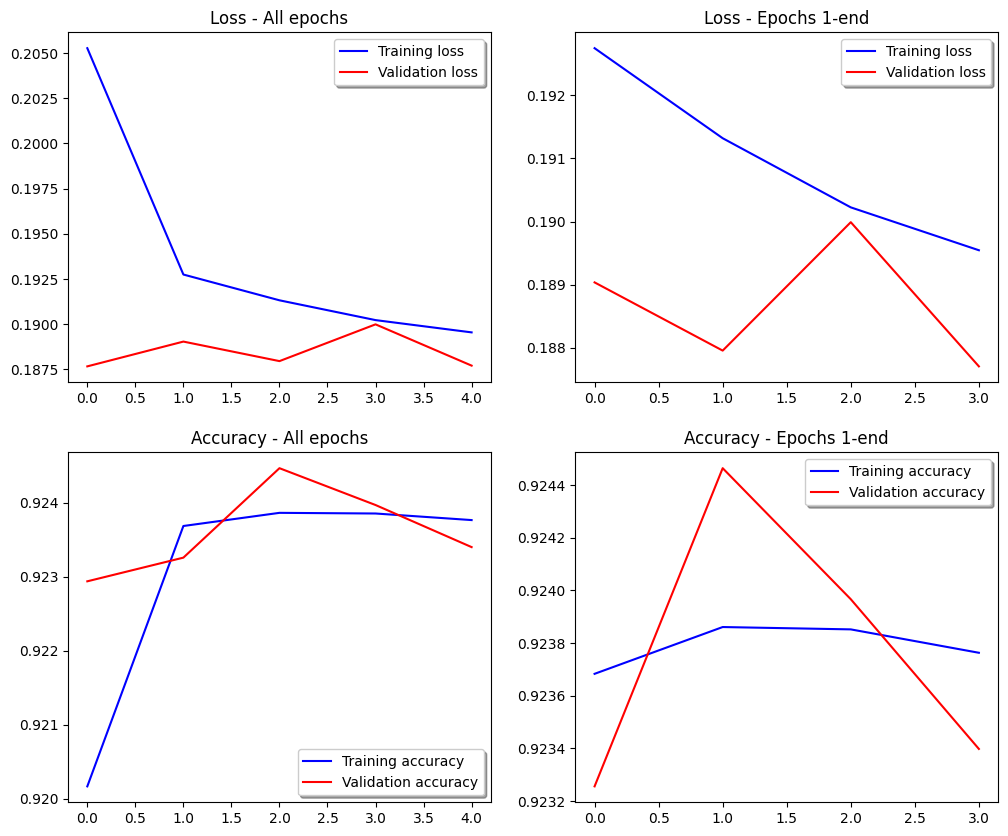

In [491]:
# Plotting the training and validation loss and accuracy
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='b', label="Training loss")
ax[0, 0].plot(val_losses, color='r', label="Validation loss")
ax[0, 0].legend(loc='best', shadow=True)
ax[0, 0].set_title("Loss - All epochs")
ax[0, 1].plot(train_losses[1:], color='b', label="Training loss")
ax[0, 1].plot(val_losses[1:], color='r', label="Validation loss")
ax[0, 1].legend(loc='best', shadow=True)
ax[0, 1].set_title("Loss - Epochs 1-end")
ax[1, 0].plot(train_accuracies, color='b', label="Training accuracy")
ax[1, 0].plot(val_accuracies, color='r', label="Validation accuracy")
ax[1, 0].legend(loc='best', shadow=True)
ax[1, 0].set_title("Accuracy - All epochs")
ax[1, 1].plot(train_accuracies[1:], color='b', label="Training accuracy")
ax[1, 1].plot(val_accuracies[1:], color='r', label="Validation accuracy")
ax[1, 1].legend(loc='best', shadow=True)
ax[1, 1].set_title("Accuracy - Epochs 1-end")
plt.show()

In [494]:
# Generate predictions for the test set
logits = train_state.apply_fn({'params': train_state.params}, test_arr, training=False)  # Get raw logits from the model
test_preds = jax.nn.sigmoid(logits)  # Apply sigmoid to convert logits to probabilities
test_preds = (test_preds > 0.5).astype(int)  # Convert probabilities to binary class predictions (0 or 1)

# Create submission file
submission['Depression'] = test_preds
submission.to_csv('submission.csv', index=False)
submission.head()

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [489]:
import flax

# Define Neural Network (MLP)
class DeepMLP(nn.Module):
    hidden_size: int
    output_size: int  # 1 for binary classification
    dropout_rate: float = 0.2

    # Define the MLP cell
    def setup(self):
        self.hidden_layer1 = nn.Dense(features=self.hidden_size)
        self.hidden_layer2 = nn.Dense(features=self.hidden_size)
        self.output_layer = nn.Dense(features=self.output_size)
    
    @nn.compact
    def __call__(self, x, training: bool):
        # Hidden Layer 1 with ReLU, BatchNorm, and Dropout
        x = self.hidden_layer1(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)

        # Hidden Layer 2 with ReLU, BatchNorm, and Dropout
        x = self.hidden_layer2(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not training)

        # Output Layer
        x = self.output_layer(x)
        return x

# Split the PRNG key to be able to use Dropout
root_key = jax.random.PRNGKey(seed=0)
main_key, params_key, dropout_key = jax.random.split(root_key, 3) 

# Create training state
class CustomTrainState(TrainState):
    dropout_key: jax.Array
    batch_stats: flax.core.FrozenDict  # add for BatchNorm

# For BatchNorm, need to adjust the trains tate to get the batch stats output
def create_train_state(params_key, dropout_key, X_train):
    X_batch = X_train[:1, :]  # Take a batch of the data to get the input size
    model = DeepMLP(hidden_size=64, output_size=1)  # Increased hidden size
    variables = model.init(params_key, X_batch, training=True)
    params = variables['params']
    batch_stats = variables['batch_stats']
    tx = optax.adamw(learning_rate=1e-3, weight_decay=1e-4)  # L2 regularization
    return CustomTrainState.create(apply_fn=model.apply, params=params, tx=tx, dropout_key=dropout_key, batch_stats=batch_stats)

# Initialis the training state
train_state = create_train_state(params_key, dropout_key, X_train_arr)

# Set up Training Loop, Loss Function and Optimizer. 
@jax.jit
def binary_cross_entropy_loss(logits, labels):
    preds = jax.nn.sigmoid(logits)  # Sigmoid activation function to get probabilities
    epsilon = 1e-7  # Small value to avoid log(0)
    loss = -jnp.mean(labels * jnp.log(preds + epsilon) + (1 - labels) * jnp.log(1 - preds + epsilon))
    return loss


# Training step function
# For BatchNorm, you need to add the batch_stats to the state
@partial(jax.jit, static_argnames=['training'])
def train_step(state: CustomTrainState, batch, training):
    dropout_key, new_dropout_key = jax.random.split(state.dropout_key)
    dropout_train_key = jax.random.fold_in(dropout_key, state.step)
    
    def loss_fn(params):
        logits, new_model_state = state.apply_fn(
            {'params': params, 'batch_stats': state.batch_stats},
            batch[0],
            training=training,
            rngs={'dropout': dropout_train_key},
            mutable=['batch_stats']
        )
        loss = binary_cross_entropy_loss(logits, batch[1])
        return loss, (logits, new_model_state)
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (logits, new_model_state)), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads).replace(dropout_key=new_dropout_key, batch_stats=new_model_state['batch_stats'])
    return loss, state

# Validation step function: also update for BatchNorm
@partial(jax.jit, static_argnames=['training'])
def validate(params, batch_stats, batch, training):
    features, labels = batch
    logits = train_state.apply_fn({'params': params, 'batch_stats': batch_stats}, features, training=training)
    loss = binary_cross_entropy_loss(logits, labels)
    return loss

# Accuracy calculation
def calculate_accuracy(logits, labels):
    preds = jax.nn.sigmoid(logits)
    predicted_classes = preds > 0.5
    return jnp.mean(predicted_classes == labels)

# Set batch size and number of epochs
batch_size = 32 
num_epochs = 20  # Increased number of epochs

# Early stopping criteria
patience = 4
best_val_loss = float('inf')
epochs_without_improvement = 0

# Training loop with validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
start = time.time()
for epoch in range(num_epochs):
    # Shuffle data for each epoch
    idx = jax.random.permutation(rng, X_train_arr.shape[0])
    X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

    # Training
    train_loss = 0.0
    train_accuracy = 0.0
    for i in range(0, len(X_train_arr), batch_size):
        batch_features = X_train_arr[i:i + batch_size]
        batch_labels = y_train_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one training step
        loss, train_state = train_step(train_state, batch, training=True)
        train_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params, 'batch_stats': train_state.batch_stats}, batch_features, training=False)
        train_accuracy += calculate_accuracy(logits, batch_labels)

    train_loss /= (len(X_train_arr) // batch_size)
    train_accuracy /= (len(X_train_arr) // batch_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss = 0.0
    val_accuracy = 0.0
    for i in range(0, len(X_test_arr), batch_size):
        batch_features = X_test_arr[i:i + batch_size]
        batch_labels = y_test_arr[i+i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one validation step
        loss = validate(train_state.params, train_state.batch_stats, batch, training=False)
        val_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params, 'batch_stats': train_state.batch_stats}, batch_features, training=False)
        val_accuracy += calculate_accuracy(logits, batch_labels)

    val_loss /= (len(X_test_arr) // batch_size)
    val_accuracy /= (len(X_test_arr) // batch_size)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Early stopping and model checkpointing
    checkpoint_dir = os.path.abspath('./checkpoints')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        checkpoints.save_checkpoint(ckpt_dir=checkpoint_dir, target=train_state.params, step=epoch, overwrite=True)
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break

print("Total time: ", time.time() - start, "seconds")

# Load the best model
best_params = checkpoints.restore_checkpoint(ckpt_dir=checkpoint_dir, target=train_state.params)

Epoch 1/20, Training Loss: 0.2163, Validation Loss: 2.6868, Training Accuracy: 0.9199, Validation Accuracy: 0.4389
Epoch 2/20, Training Loss: 0.2040, Validation Loss: 2.7475, Training Accuracy: 0.9230, Validation Accuracy: 0.4377
Epoch 3/20, Training Loss: 0.2015, Validation Loss: 2.6677, Training Accuracy: 0.9230, Validation Accuracy: 0.4349


KeyboardInterrupt: 

# Handling the target variable (Depression) imbalance
As shown above, there are more people without depression compared to depression cases. I can do two things
1. Modify the loss function to account for class imbalance -> this seems to make things worse
2. Over-sampling/under-sampling, use SMOTE (Synthetic Minority Oversampling Technique) -> this also seems to make things worse

### Conclusion
Taking account for class imbalance doesn't help. In fact, it made both the losses and accuracies worse. It seems that the model
does actually well with imbalanced classes. 

Epoch 1/20, Training Loss: 0.2630, Validation Loss: 0.2492, Training Accuracy: 0.8813, Validation Accuracy: 0.8896
Epoch 2/20, Training Loss: 0.2470, Validation Loss: 0.2501, Training Accuracy: 0.8918, Validation Accuracy: 0.9015
Epoch 3/20, Training Loss: 0.2458, Validation Loss: 0.2466, Training Accuracy: 0.8927, Validation Accuracy: 0.8960
Epoch 4/20, Training Loss: 0.2449, Validation Loss: 0.2466, Training Accuracy: 0.8934, Validation Accuracy: 0.8945
Epoch 5/20, Training Loss: 0.2443, Validation Loss: 0.2485, Training Accuracy: 0.8940, Validation Accuracy: 0.9016
Epoch 6/20, Training Loss: 0.2439, Validation Loss: 0.2476, Training Accuracy: 0.8945, Validation Accuracy: 0.8900
Epoch 7/20, Training Loss: 0.2437, Validation Loss: 0.2468, Training Accuracy: 0.8944, Validation Accuracy: 0.9000
Epoch 8/20, Training Loss: 0.2431, Validation Loss: 0.2479, Training Accuracy: 0.8947, Validation Accuracy: 0.8851
Epoch 9/20, Training Loss: 0.2429, Validation Loss: 0.2475, Training Accuracy: 0

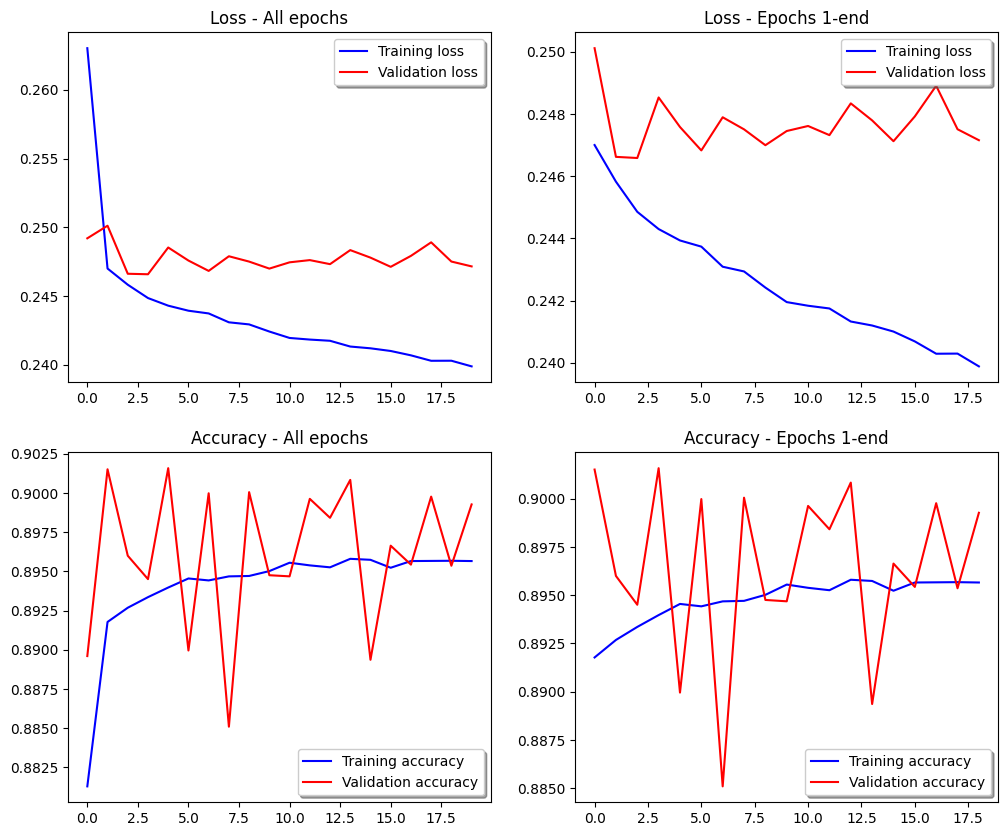

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [405]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# import jax
# import jax.numpy as jnp
# import optax
# from flax import linen as nn
# from flax.training import train_state
# import time
# import matplotlib.pyplot as plt
# from pathlib import Path
# from sklearn.utils.class_weight import compute_class_weight

# # Load data
# data_path = Path("~/Data/mental_health/")
# train = pd.read_csv(data_path / "train.csv", header=0, index_col=0)
# test = pd.read_csv(data_path / "test.csv", header=0, index_col=0)
# submission = pd.read_csv(data_path / "sample_submission.csv")

# # Select the columns that are continuous and have 2 categories
# selected_columns = [
#     'Gender', 
#     'Working Professional or Student', 
#     'Have you ever had suicidal thoughts ?', 
#     'Family History of Mental Illness', 
#     'Age', 
#     'Work/Study Hours', 
#     'Financial Stress', 
#     'Job Satisfaction', 
# ]

# # Prepare the data for training
# X = train[selected_columns]
# y = train['Depression']

# # Drop the same columns from the test set
# test_selected = test[selected_columns]

# # Combine train and test to ensure consistent one-hot encoding
# combined = pd.concat([X, test_selected], keys=['train', 'test'])

# # One-hot encode the categorical variables
# cat_cols = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
# combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

# # Split back into train and test sets
# X = combined.xs('train')
# test_selected = combined.xs('test')

# # Fill missing values with the mean of the column for numeric columns
# X = X.fillna(X.mean())
# test_selected = test_selected.fillna(test_selected.mean())

# # Ensure all values are numeric
# X = X.apply(pd.to_numeric, errors='coerce')
# test_selected = test_selected.apply(pd.to_numeric, errors='coerce')

# # Separate continuous and categorical features
# continuous_features = ['Age', 'Work/Study Hours', 'Financial Stress', 'Job Satisfaction']
# categorical_features = [col for col in X.columns if col not in continuous_features]

# # Apply StandardScaler to continuous features
# scaler = StandardScaler()
# X_continuous = scaler.fit_transform(X[continuous_features])
# test_selected_continuous = scaler.transform(test_selected[continuous_features])

# # Combine scaled continuous features and categorical features
# X_combined = np.hstack((X_continuous, X[categorical_features].values))
# test_selected_combined = np.hstack((test_selected_continuous, test_selected[categorical_features].values))

# # Split data into training and validation sets -> 80% train, 20% validation
# train_size = int(0.8 * len(X_combined))
# X_train, X_val = X_combined[:train_size], X_combined[train_size:]
# y_train, y_val = y.values[:train_size], y.values[train_size:]

# # Compute class weights
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights = jnp.array(class_weights, dtype=jnp.float32)

# # Convert data into JAX arrays with specified dtype
# X_train_arr = jnp.array(X_train, dtype=jnp.float32)
# y_train_arr = jnp.array(y_train, dtype=jnp.float32).reshape(-1, 1)
# X_val_arr = jnp.array(X_val, dtype=jnp.float32)
# y_val_arr = jnp.array(y_val, dtype=jnp.float32).reshape(-1, 1)
# test_arr = jnp.array(test_selected_combined, dtype=jnp.float32)

# # Define Neural Network (MLP)
# class SimpleMLP(nn.Module):
#     hidden_size: int
#     output_size: int  # 1 for binary classification

#     def setup(self):
#         self.hidden_layer1 = nn.Dense(features=self.hidden_size)
#         self.hidden_layer2 = nn.Dense(features=self.hidden_size)
#         self.hidden_layer3 = nn.Dense(features=self.hidden_size)
#         self.output_layer = nn.Dense(features=self.output_size)

#     def __call__(self, x):
#         x = self.hidden_layer1(x)
#         x = nn.relu(x)
#         x = self.hidden_layer2(x)
#         x = nn.relu(x)
#         x = self.hidden_layer3(x)
#         x = nn.relu(x)
#         x = self.output_layer(x)
#         return x

# # Create training state
# def create_train_state(rng, X_train):
#     X_batch = X_train[:1, :]  # Take a batch of the data to get the input size
#     model = SimpleMLP(hidden_size=128, output_size=1)  # Increased hidden size
#     params = model.init(rng, X_batch)["params"]
#     tx = optax.adam(learning_rate=1e-4)  # Adjusted learning rate
#     return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# # Initialize the training state
# rng = jax.random.PRNGKey(0)
# train_state = create_train_state(rng, X_train_arr)

# # Set up Training Loop, Loss Function and Optimizer
# @jax.jit
# def binary_cross_entropy_loss(logits, labels, class_weights):
#     # Compute binary cross-entropy loss with class weights
#     preds = jax.nn.sigmoid(logits)  # Sigmoid activation function to get probabilities
#     epsilon = 1e-7  # Small value to avoid log(0)
#     loss = -jnp.mean(class_weights[1] * labels * jnp.log(preds + epsilon) + class_weights[0] * (1 - labels) * jnp.log(1 - preds + epsilon))
#     return loss

# # Forward pass and loss calculation
# @jax.jit
# def compute_loss(params, batch, class_weights):
#     features, labels = batch
#     logits = train_state.apply_fn({'params': params}, features)  # Get raw logits from the model
#     return binary_cross_entropy_loss(logits, labels, class_weights)

# # Training step function
# @jax.jit
# def train_step(state, batch, class_weights):
#     loss, grads = jax.value_and_grad(compute_loss)(state.params, batch, class_weights)  # Compute loss and gradients
#     state = state.apply_gradients(grads=grads)  # Apply updates to the model parameters
#     return loss, state

# # Validation step function
# @jax.jit
# def validate(params, batch, class_weights):
#     features, labels = batch
#     logits = train_state.apply_fn({'params': params}, features)  # Get raw logits from the model
#     loss = binary_cross_entropy_loss(logits, labels, class_weights)
#     return loss

# # Accuracy calculation
# def calculate_accuracy(logits, labels):
#     preds = jax.nn.sigmoid(logits)
#     predicted_classes = preds > 0.5
#     return jnp.mean(predicted_classes == labels)

# # Set batch size and number of epochs
# batch_size = 32 
# num_epochs = 20  # Increased number of epochs

# # Training loop with validation
# train_losses, val_losses = [], []
# train_accuracies, val_accuracies = [], []
# start = time.time()
# for epoch in range(num_epochs):
#     # Shuffle data for each epoch
#     idx = jax.random.permutation(rng, X_train_arr.shape[0])
#     X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

#     # Training
#     train_loss = 0.0
#     train_accuracy = 0.0
#     for i in range(0, len(X_train_arr), batch_size):
#         batch_features = X_train_arr[i:i + batch_size]
#         batch_labels = y_train_arr[i:i + batch_size]
#         batch = (batch_features, batch_labels)

#         # Perform one training step
#         loss, train_state = train_step(train_state, batch, class_weights)
#         train_loss += loss

#         # Calculate accuracy
#         logits = train_state.apply_fn({'params': train_state.params}, batch_features)
#         train_accuracy += calculate_accuracy(logits, batch_labels)

#     train_loss /= (len(X_train_arr) // batch_size)
#     train_accuracy /= (len(X_train_arr) // batch_size)
#     train_losses.append(train_loss)
#     train_accuracies.append(train_accuracy)

#     # Validation
#     val_loss = 0.0
#     val_accuracy = 0.0
#     for i in range(0, len(X_val_arr), batch_size):
#         batch_features = X_val_arr[i:i + batch_size]
#         batch_labels = y_val_arr[i:i + batch_size]
#         batch = (batch_features, batch_labels)

#         # Perform one validation step
#         loss = validate(train_state.params, batch, class_weights)
#         val_loss += loss

#         # Calculate accuracy
#         logits = train_state.apply_fn({'params': train_state.params}, batch_features)
#         val_accuracy += calculate_accuracy(logits, batch_labels)

#     val_loss /= (len(X_val_arr) // batch_size)
#     val_accuracy /= (len(X_val_arr) // batch_size)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)

#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# print("Total time: ", time.time() - start, "seconds")

# # Plotting the training and validation loss and accuracy
# fig, ax = plt.subplots(2, 2, figsize=(12, 10))
# ax[0, 0].plot(train_losses, color='b', label="Training loss")
# ax[0, 0].plot(val_losses, color='r', label="Validation loss")
# ax[0, 0].legend(loc='best', shadow=True)
# ax[0, 0].set_title("Loss - All epochs")
# ax[0, 1].plot(train_losses[1:], color='b', label="Training loss")
# ax[0, 1].plot(val_losses[1:], color='r', label="Validation loss")
# ax[0, 1].legend(loc='best', shadow=True)
# ax[0, 1].set_title("Loss - Epochs 1-end")
# ax[1, 0].plot(train_accuracies, color='b', label="Training accuracy")
# ax[1, 0].plot(val_accuracies, color='r', label="Validation accuracy")
# ax[1, 0].legend(loc='best', shadow=True)
# ax[1, 0].set_title("Accuracy - All epochs")
# ax[1, 1].plot(train_accuracies[1:], color='b', label="Training accuracy")
# ax[1, 1].plot(val_accuracies[1:], color='r', label="Validation accuracy")
# ax[1, 1].legend(loc='best', shadow=True)
# ax[1, 1].set_title("Accuracy - Epochs 1-end")
# plt.show()

# # Generate predictions for the test set
# logits = train_state.apply_fn({'params': train_state.params}, test_arr)
# test_preds = jax.nn.sigmoid(logits)
# test_preds = (test_preds > 0.5).astype(int)

# # Create submission file
# submission['Depression'] = test_preds
# # submission.to_csv('submission.csv', index=False)
# submission.head()

Epoch 1/20, Training Loss: 0.3229, Validation Loss: 0.2633, Training Accuracy: 0.8698, Validation Accuracy: 0.8899
Epoch 2/20, Training Loss: 0.2458, Validation Loss: 0.2551, Training Accuracy: 0.9007, Validation Accuracy: 0.8940
Epoch 3/20, Training Loss: 0.2428, Validation Loss: 0.2540, Training Accuracy: 0.9019, Validation Accuracy: 0.8938
Epoch 4/20, Training Loss: 0.2414, Validation Loss: 0.2553, Training Accuracy: 0.9027, Validation Accuracy: 0.8925
Epoch 5/20, Training Loss: 0.2406, Validation Loss: 0.2511, Training Accuracy: 0.9030, Validation Accuracy: 0.8947
Epoch 6/20, Training Loss: 0.2400, Validation Loss: 0.2457, Training Accuracy: 0.9032, Validation Accuracy: 0.8975
Epoch 7/20, Training Loss: 0.2396, Validation Loss: 0.2449, Training Accuracy: 0.9034, Validation Accuracy: 0.8980
Epoch 8/20, Training Loss: 0.2393, Validation Loss: 0.2480, Training Accuracy: 0.9035, Validation Accuracy: 0.8968
Epoch 9/20, Training Loss: 0.2390, Validation Loss: 0.2458, Training Accuracy: 0

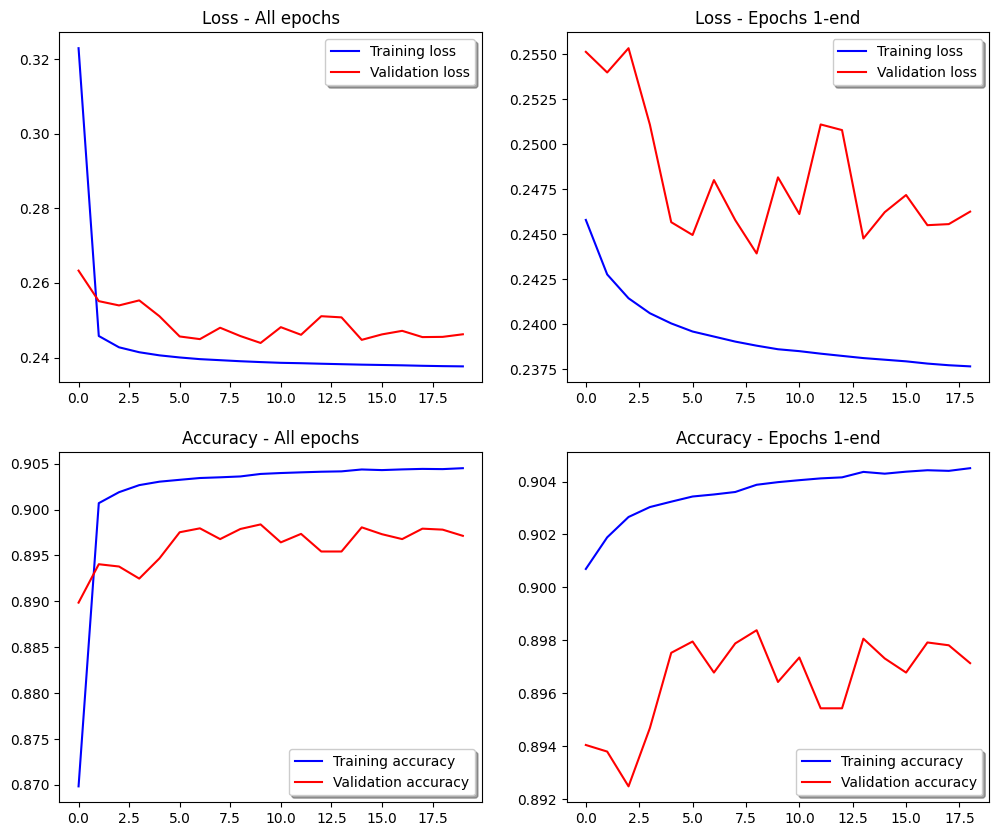

,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0


In [406]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import jax
import jax.numpy as jnp
import optax
from flax import linen as nn
from flax.training import train_state
import time
import matplotlib.pyplot as plt
from pathlib import Path
from imblearn.over_sampling import SMOTE

# Load data
data_path = Path("~/Data/mental_health/")
train = pd.read_csv(data_path / "train.csv", header=0, index_col=0)
test = pd.read_csv(data_path / "test.csv", header=0, index_col=0)
submission = pd.read_csv(data_path / "sample_submission.csv")

# Select the columns that are continuous and have 2 categories
selected_columns = [
    'Gender', 
    'Working Professional or Student', 
    'Have you ever had suicidal thoughts ?', 
    'Family History of Mental Illness', 
    'Age', 
    'Work/Study Hours', 
    'Financial Stress', 
    'Job Satisfaction', 
]

# Prepare the data for training
X = train[selected_columns]
y = train['Depression']

# Drop the same columns from the test set
test_selected = test[selected_columns]

# Combine train and test to ensure consistent one-hot encoding
combined = pd.concat([X, test_selected], keys=['train', 'test'])

# One-hot encode the categorical variables
cat_cols = ['Gender', 'Working Professional or Student', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
combined = pd.get_dummies(combined, columns=cat_cols, drop_first=True)

# Split back into train and test sets
X = combined.xs('train')
test_selected = combined.xs('test')

# Fill missing values with the mean of the column for numeric columns
X = X.fillna(X.mean())
test_selected = test_selected.fillna(test_selected.mean())

# Ensure all values are numeric
X = X.apply(pd.to_numeric, errors='coerce')
test_selected = test_selected.apply(pd.to_numeric, errors='coerce')

# Separate continuous and categorical features
continuous_features = ['Age', 'Work/Study Hours', 'Financial Stress', 'Job Satisfaction']
categorical_features = [col for col in X.columns if col not in continuous_features]

# Apply StandardScaler to continuous features
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X[continuous_features])
test_selected_continuous = scaler.transform(test_selected[continuous_features])

# Combine scaled continuous features and categorical features
X_combined = np.hstack((X_continuous, X[categorical_features].values))
test_selected_combined = np.hstack((test_selected_continuous, test_selected[categorical_features].values))

# Split data into training and validation sets -> 80% train, 20% validation
train_size = int(0.8 * len(X_combined))
X_train, X_val = X_combined[:train_size], X_combined[train_size:]
y_train, y_val = y.values[:train_size], y.values[train_size:]

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Convert data into JAX arrays with specified dtype
X_train_arr = jnp.array(X_train_smote, dtype=jnp.float32)
y_train_arr = jnp.array(y_train_smote, dtype=jnp.float32).reshape(-1, 1)
X_val_arr = jnp.array(X_val, dtype=jnp.float32)
y_val_arr = jnp.array(y_val, dtype=jnp.float32).reshape(-1, 1)
test_arr = jnp.array(test_selected_combined, dtype=jnp.float32)

# Define Neural Network (MLP)
class SimpleMLP(nn.Module):
    hidden_size: int
    output_size: int  # 1 for binary classification

    def setup(self):
        self.hidden_layer = nn.Dense(features=self.hidden_size)
        self.output_layer = nn.Dense(features=self.output_size)

    def __call__(self, x):
        x = self.hidden_layer(x)
        x = nn.relu(x)
        x = self.output_layer(x)
        return x

# Create training state
def create_train_state(rng, X_train):
    X_batch = X_train[:1, :]  # Take a batch of the data to get the input size
    model = SimpleMLP(hidden_size=64, output_size=1)  # Original hidden size
    params = model.init(rng, X_batch)["params"]
    tx = optax.adam(learning_rate=1e-4)  # Adjusted learning rate
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Initialize the training state
rng = jax.random.PRNGKey(0)
train_state = create_train_state(rng, X_train_arr)

# Set up Training Loop, Loss Function and Optimizer
@jax.jit
def binary_cross_entropy_loss(logits, labels):
    # Compute binary cross-entropy loss
    preds = jax.nn.sigmoid(logits)  # Sigmoid activation function to get probabilities
    epsilon = 1e-7  # Small value to avoid log(0)
    loss = -jnp.mean(labels * jnp.log(preds + epsilon) + (1 - labels) * jnp.log(1 - preds + epsilon))
    return loss

# Forward pass and loss calculation
@jax.jit
def compute_loss(params, batch):
    features, labels = batch
    logits = train_state.apply_fn({'params': params}, features)  # Get raw logits from the model
    return binary_cross_entropy_loss(logits, labels)

# Training step function
@jax.jit
def train_step(state, batch):
    loss, grads = jax.value_and_grad(compute_loss)(state.params, batch)  # Compute loss and gradients
    state = state.apply_gradients(grads=grads)  # Apply updates to the model parameters
    return loss, state

# Validation step function
@jax.jit
def validate(params, batch):
    features, labels = batch
    logits = train_state.apply_fn({'params': params}, features)  # Get raw logits from the model
    loss = binary_cross_entropy_loss(logits, labels)
    return loss

# Accuracy calculation
def calculate_accuracy(logits, labels):
    preds = jax.nn.sigmoid(logits)
    predicted_classes = preds > 0.5
    return jnp.mean(predicted_classes == labels)

# Set batch size and number of epochs
batch_size = 32 
num_epochs = 20  # Increased number of epochs

# Training loop with validation
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
start = time.time()
for epoch in range(num_epochs):
    # Shuffle data for each epoch
    idx = jax.random.permutation(rng, X_train_arr.shape[0])
    X_train_arr, y_train_arr = X_train_arr[idx], y_train_arr[idx]

    # Training
    train_loss = 0.0
    train_accuracy = 0.0
    for i in range(0, len(X_train_arr), batch_size):
        batch_features = X_train_arr[i:i + batch_size]
        batch_labels = y_train_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one training step
        loss, train_state = train_step(train_state, batch)
        train_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features)
        train_accuracy += calculate_accuracy(logits, batch_labels)

    train_loss /= (len(X_train_arr) // batch_size)
    train_accuracy /= (len(X_train_arr) // batch_size)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    val_loss = 0.0
    val_accuracy = 0.0
    for i in range(0, len(X_val_arr), batch_size):
        batch_features = X_val_arr[i:i + batch_size]
        batch_labels = y_val_arr[i:i + batch_size]
        batch = (batch_features, batch_labels)

        # Perform one validation step
        loss = validate(train_state.params, batch)
        val_loss += loss

        # Calculate accuracy
        logits = train_state.apply_fn({'params': train_state.params}, batch_features)
        val_accuracy += calculate_accuracy(logits, batch_labels)

    val_loss /= (len(X_val_arr) // batch_size)
    val_accuracy /= (len(X_val_arr) // batch_size)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("Total time: ", time.time() - start, "seconds")

# Plotting the training and validation loss and accuracy
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='b', label="Training loss")
ax[0, 0].plot(val_losses, color='r', label="Validation loss")
ax[0, 0].legend(loc='best', shadow=True)
ax[0, 0].set_title("Loss - All epochs")
ax[0, 1].plot(train_losses[1:], color='b', label="Training loss")
ax[0, 1].plot(val_losses[1:], color='r', label="Validation loss")
ax[0, 1].legend(loc='best', shadow=True)
ax[0, 1].set_title("Loss - Epochs 1-end")
ax[1, 0].plot(train_accuracies, color='b', label="Training accuracy")
ax[1, 0].plot(val_accuracies, color='r', label="Validation accuracy")
ax[1, 0].legend(loc='best', shadow=True)
ax[1, 0].set_title("Accuracy - All epochs")
ax[1, 1].plot(train_accuracies[1:], color='b', label="Training accuracy")
ax[1, 1].plot(val_accuracies[1:], color='r', label="Validation accuracy")
ax[1, 1].legend(loc='best', shadow=True)
ax[1, 1].set_title("Accuracy - Epochs 1-end")
plt.show()

# Generate predictions for the test set
logits = train_state.apply_fn({'params': train_state.params}, test_arr)
test_preds = jax.nn.sigmoid(logits)
test_preds = (test_preds > 0.5).astype(int)

# Create submission file
submission['Depression'] = test_preds
# submission.to_csv('submission.csv', index=False)
submission.head()